# Вебинар 2. Бейзлайны и детерминированные алгоритмы item-item

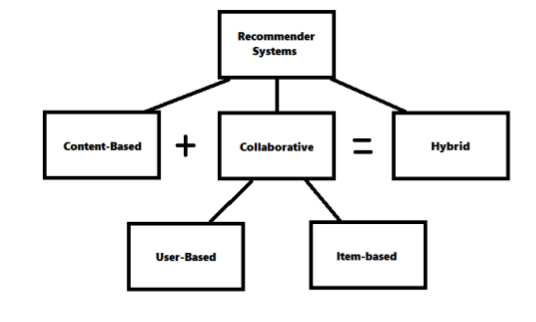

In [1]:
# !pip install implicit

[Implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) - очень быстрая и 
эффективная библиотека для рекоммендаций

Основные фичи:
- Cython под капотом - высокая скорость
- Множество приближенных алгоритмов - быстрее, чем оригинальные
- Содежрит большинство популярных алгоритмов
- Есть алгоритмы ранжирования
- Поиск похожих товаров / юзеров
- Есть возможность пересчета "холодного" юзера "на лету"
- Возможность фильтровать товары при рекомендациях (Например, не рекомендовать женские товары мужчинам)
- Есть метрики качества

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [3]:
data = pd.read_csv('data/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
data['week_no'].nunique()

95

In [5]:
users, items, interactions = data.user_id.nunique(), data.item_id.nunique(), data.shape[0]

print('# users: ', users)
print('# items: ', items)
print('# interactions: ', interactions)

# users:  2499
# items:  89051
# interactions:  2396804


In [6]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
popularity.sort_values(by='sales_value', ascending=False)

,item_id,sales_value
56233,6534178,467993.62
56193,6533889,42645.75
29195,1029743,37981.91
56228,6534166,31298.96
35054,1082185,27291.02
...,...,...
33061,1064300,0.00
15029,902904,0.00
88691,17179257,0.00
78291,12987822,0.00


In [7]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
popularity.describe()

,item_id,sales_value
count,8.905100e+04,89051.000000
mean,5.115772e+06,83.458481
std,5.178973e+06,1628.715079
min,2.567100e+04,0.000000
25%,9.665830e+05,3.500000
50%,1.448516e+06,10.780000
75%,9.553042e+06,46.105000
max,1.802456e+07,467993.620000


In [8]:
popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
popularity.sort_values(by='user_id', ascending=False)

,item_id,user_id
35054,1082185,2039
23846,981760,1584
25333,995242,1421
29195,1029743,1345
8056,840361,1319
...,...,...
27618,1015417,1
57829,6919298,1
57833,6919307,1
57834,6919308,1


In [9]:
popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
popularity.describe()

,item_id,user_id
count,8.905100e+04,89051.000000
mean,5.115772e+06,14.759767
std,5.178973e+06,45.904111
min,2.567100e+04,1.000000
25%,9.665830e+05,1.000000
50%,1.448516e+06,2.000000
75%,9.553042e+06,10.000000
max,1.802456e+07,2039.000000


**Note:**  
Еще есть данные по характеристикам товаров и пользователей. Они нам пригодятся через несколько вебинаров

In [10]:
item_features = pd.read_csv('data/product.csv')
item_features.head(2)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [11]:
user_features = pd.read_csv('data/hh_demographic.csv')
user_features.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


### Train-test split

В рекомендательных системах корректнее использовать train-test split по времени, а не случайно  
Я возьму последние 3 недели в качестве теста

In [12]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [13]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

# 1. Бейзлайны

Создадим датафрейм с покупками юзеров на тестовом датасете (последние 3 недели)

In [14]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [15]:
test_users = result.shape[0]
new_test_users = len(set(data_test['user_id']) - set(data_train['user_id']))

print('В тестовом дата сете {} юзеров'.format(test_users))
print('В тестовом дата сете {} новых юзеров'.format(new_test_users))

В тестовом дата сете 2042 юзеров
В тестовом дата сете 0 новых юзеров


### 1.1 Random recommendation

In [16]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    
    return recs.tolist()

In [17]:
%%time

items = data_train.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))
result.head(2)

Wall time: 3.78 s


,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[823247, 6633232, 795231, 9553316, 63933]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1951135, 13416941, 15512233, 9218671, 912991]"


### 1.2 Popularity-based recommendation

In [18]:
def popularity_sum_values_recommendation(data, n=5):
    """Топ-n популярных товаров по сумме покупок"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [19]:
def popularity_sum_counts_recommendation(data, n=5):
    """Топ-n популярных товаров по числу покупок"""
    
    popular = data.groupby('item_id')['user_id'].nunique().reset_index()
    popular.sort_values('user_id', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [20]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [21]:
%%time

# Можно так делать, так как рекомендация не зависит от юзера
popular_sum_values_recs = popularity_sum_values_recommendation(data_train, n=5)
popular_sum_counts_recs = popularity_sum_counts_recommendation(data_train, n=5)

result['popular_values_recommendation'] = result['user_id'].apply(lambda x: popular_sum_values_recs)
result['popular_counts_recommendation'] = result['user_id'].apply(lambda x: popular_sum_counts_recs)
result.head(2)

Wall time: 1.24 s


,user_id,actual,random_recommendation,popular_values_recommendation,popular_counts_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[823247, 6633232, 795231, 9553316, 63933]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1951135, 13416941, 15512233, 9218671, 912991]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]"


### 1.3 Weighted random recommender

- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

*Пример*  
item_1 - 5, item_2 - 7, item_3 - 4  # / sum  
item_1 - 5 / 16, item_2 - 7 / 16, item_3 - 4 / 16

In [22]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    return recs.tolist()

In [23]:
%%time

# your_code

Wall time: 0 ns


### Выводы по бейзлайнам
- Фиксируют базовое качество;
- Бейзлайны могут быть фильтрами;
- Иногда бейзлайны лучше ML-модели

# 2. Детерминированные алгоритмы item-item

## 2.1 Item-Item Recommender / ItemKNN

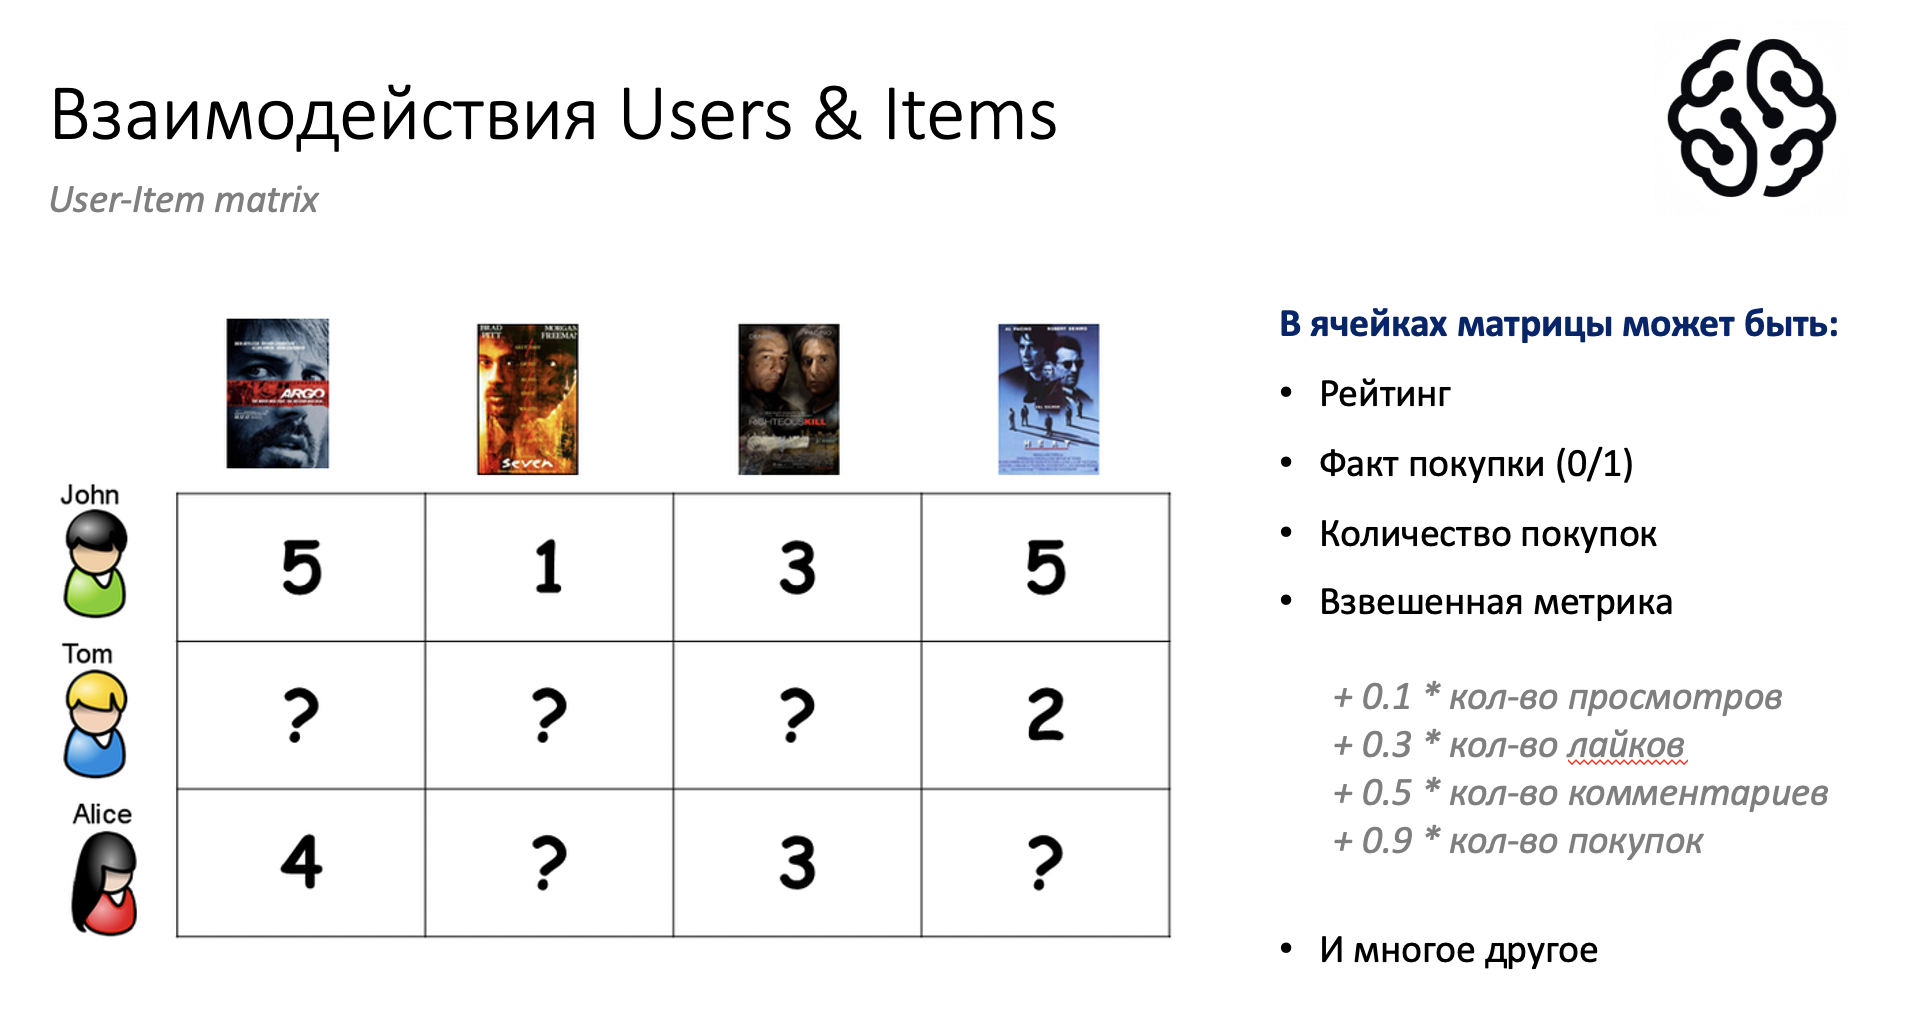

То, что именно находится в матрице user-item нужно определять из бизнес-логики

Варианты для нашего датасета(не исчерпывающий список):
- Факт покупки (0 / 1)
- Кол-во покупок (count)
- Сумма покупки, руб
- ...
    
**Детерминированные алгоритмы**:
- Предсказывают те числа, которые стоят в матрице

**ML-алгоритмы (большинство)**:
- В качестве *таргетов* "под капотом" принимают 0 и 1 (в ячейке не 0 -> таргет 1)
- А абсолютные значения воспринимают как *веса ошибок*
    
*P.S.* На самом деле есть много трюков, как можно заполнять матрицу user-item. Об этом мы поговорим на следующих вебинарах

**Как работает Item-Item Recommender**

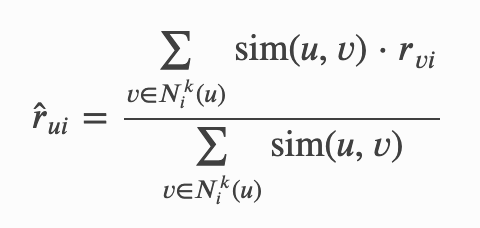

*Шаг 1:* Ищем K ближайших юзеров к целевому юзеру  
*Шаг 2*: predict "скора" товара = среднему "скору" этого товара у его соседей  
*Шаг 3*: Сортируем товары по убыванию predict-ов и берем топ-k

----
**(!) Важно** 
- У item-item алгоритмов большая сложность predict ($O(I^2 log(I))$ или $O(I^3)$, в зависимости от реализации 
- Если в датасете много item_id, то item-item модели ОЧЕНЬ долго предсказывают. Со всеми товарами predict на тесте ~2 часа
- Давайте возьмем из ~90к товаров только 5k самых популярных 

*P.S.*  Брать топ-Х популярных и рекомендовать только из них - очень популярная стратегия.   
*P.P.S.*  В рекомендательных системах много таких трюков. Что-то подобное в курсе вы увидите еще не раз

In [24]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [25]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [26]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
user_item_matrix.shape

(2499, 5001)

In [28]:
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

5.33770796861036

In [29]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [30]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 791 ms


In [31]:
recs

[(2381, 78679.0),
 (3408, 72173.0),
 (2148, 57995.0),
 (3947, 17272.0),
 (3587, 14417.0)]

In [32]:
[id_to_itemid[rec[0]] for rec in recs]

[999999, 1082185, 981760, 1127831, 1098066]

In [33]:
%%time

result['itemitem'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

Wall time: 56 ms


In [34]:
result.head(2)

,user_id,actual,random_recommendation,popular_values_recommendation,popular_counts_recommendation,itemitem
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[823247, 6633232, 795231, 9553316, 63933]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]","[999999, 1082185, 981760, 1127831, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1951135, 13416941, 15512233, 9218671, 912991]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]","[999999, 1082185, 981760, 1098066, 995242]"


### 4.2 Косинусное сходство и CosineRecommender

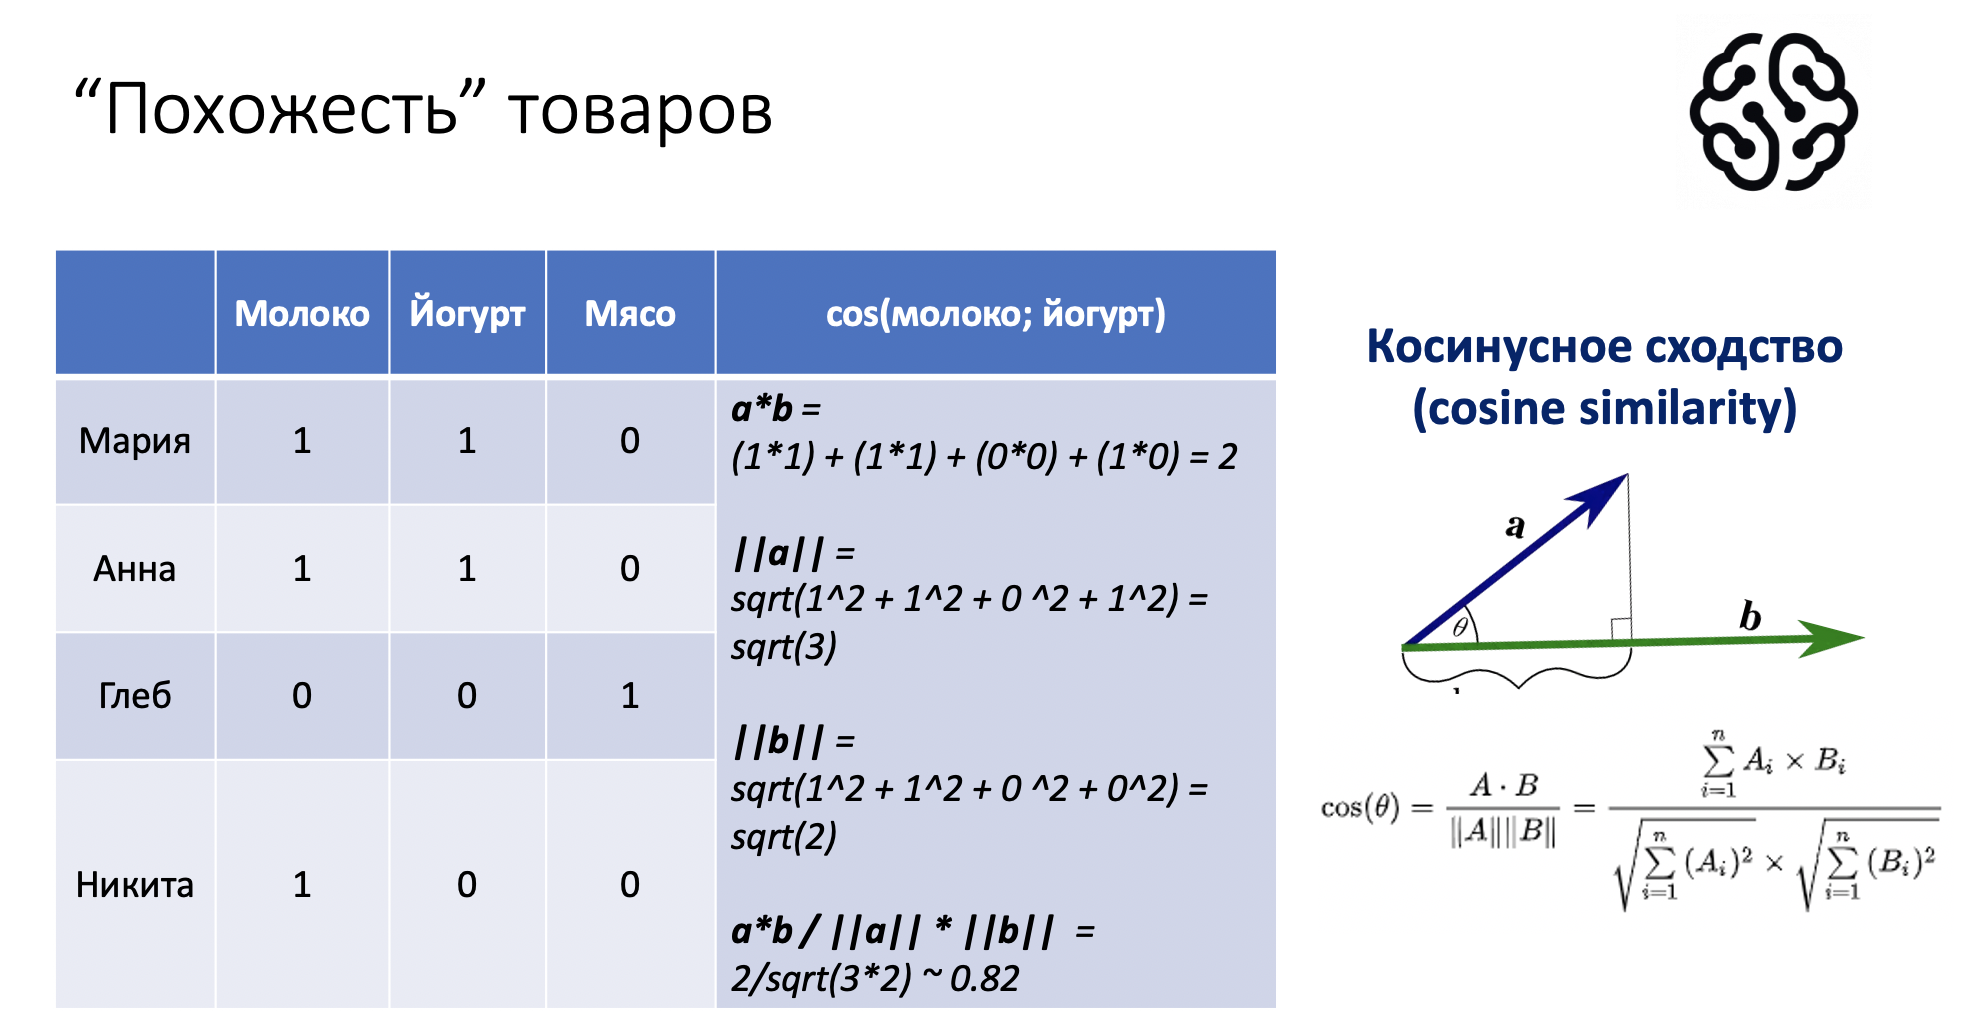

In [35]:
%%time

model = CosineRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 790 ms


In [36]:
[id_to_itemid[rec[0]] for rec in recs]

[1082185, 999999, 981760, 1127831, 1098066]

In [37]:
%%time

result['cosine'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

Wall time: 63 ms


In [38]:
result.head(2)

,user_id,actual,random_recommendation,popular_values_recommendation,popular_counts_recommendation,itemitem,cosine
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[823247, 6633232, 795231, 9553316, 63933]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1951135, 13416941, 15512233, 9218671, 912991]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]"


### 4.3 TF-IDF взвешивание и TFIDFRecommender

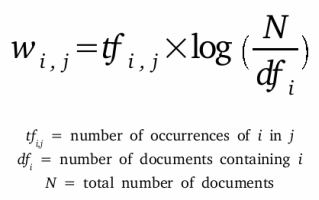

Если 2 юзера оба купили очень популярный товар, то это еще не значит,что они похожи   
Если 2 юзера оба купили редкий товар, то они похожи

Занижаем вес популярных товаров при расчете расстояний между пользователями

In [39]:
%%time

model = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 812 ms


In [40]:
[id_to_itemid[rec[0]] for rec in recs]

[1082185, 981760, 1127831, 999999, 1098066]

In [41]:
%%time

result['tfidf'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=False)])

Wall time: 65 ms


In [42]:
result.head(2)

,user_id,actual,random_recommendation,popular_values_recommendation,popular_counts_recommendation,itemitem,cosine,tfidf
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[823247, 6633232, 795231, 9553316, 63933]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1951135, 13416941, 15512233, 9218671, 912991]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]"


### 4.4 Трюк

In [43]:
%%time

model = ItemItemRecommender(K=1, num_threads=4) # K - кол-во ближайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 769 ms


In [44]:
[id_to_itemid[rec[0]] for rec in recs]

[999999, 1082185, 1029743, 995785, 1004906]

In [45]:
%%time

result['own_purchases'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[999999],
                                    recalculate_user=False)])

Wall time: 54 ms


In [46]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации на основании весов
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
        Первый столбец item_id
        Второй столбец weight
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    recs = np.random.choice(items_weights.iloc[:, 0], size=n, replace=False, p=items_weights.iloc[:, 1])
    
    
    return recs.tolist()

In [47]:
%%time

# your_code
items_weights = data_train[['item_id', 'sales_value']]
items_weights['weight'] = items_weights['sales_value']/data_train['sales_value'].sum()
items_weights = items_weights[['item_id', 'weight']]

random_weight_recommendation = weighted_random_recommendation(items_weights, n=5)

result['random_weight_recommendation'] = result['user_id'].apply(lambda x: random_weight_recommendation)
result.head(2)

Wall time: 108 ms


<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,user_id,actual,random_recommendation,popular_values_recommendation,popular_counts_recommendation,itemitem,cosine,tfidf,own_purchases,random_weight_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[823247, 6633232, 795231, 9553316, 63933]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]","[832678, 932675, 879528, 866528, 999999]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1951135, 13416941, 15512233, 9218671, 912991]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]","[832678, 932675, 879528, 866528, 999999]"


### 4.5 Измерим качество по precision@5

In [48]:
result.head(2)

,user_id,actual,random_recommendation,popular_values_recommendation,popular_counts_recommendation,itemitem,cosine,tfidf,own_purchases,random_weight_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[823247, 6633232, 795231, 9553316, 63933]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]","[832678, 932675, 879528, 866528, 999999]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1951135, 13416941, 15512233, 9218671, 912991]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 995242, 1029743, 840361]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]","[832678, 932675, 879528, 866528, 999999]"


In [49]:
result.to_csv('output/predictions_basic.csv', index=False)

In [50]:
# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k

In [51]:
result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()


0.0007835455435847208

In [52]:
result.apply(lambda row: precision_at_k(row['popular_values_recommendation'], row['actual']), axis=1).mean()

0.15523996082272082

In [53]:
result.apply(lambda row: precision_at_k(row['popular_counts_recommendation'], row['actual']), axis=1).mean()

0.19285014691478689

In [54]:
result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()

0.13692458374142857

In [55]:
result.apply(lambda row: precision_at_k(row['cosine'], row['actual']), axis=1).mean()

0.13290891283055686

In [56]:
result.apply(lambda row: precision_at_k(row['tfidf'], row['actual']), axis=1).mean()

0.1389813907933383

In [57]:
result.apply(lambda row: precision_at_k(row['own_purchases'], row['actual']), axis=1).mean()

0.17969311132876015

In [58]:
result.apply(lambda row: precision_at_k(row['random_weight_recommendation'], row['actual']), axis=1).mean()

0.008716944172380009